# Twitter Sentiment Classification Task.

-The dataset (twitter_training.csv) contains tweets labeled with sentiment categories (Irrelevant, Negative, Neutral, Positive).

-The goal is to build a text classification model that can automatically predict the sentiment of unseen tweets.

Your pipeline includes:

-EDA (Exploratory Data Analysis): inspecting class balance, text length, duplicates, and missing values.

-Preprocessing: vectorizing tweets into numerical form using TextVectorization.

-Modeling: training a Transformer-based classifier in TensorFlow/Keras.

-Evaluation: tracking accuracy & macro-F1 (important due to class imbalance).



## libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Loading

In [ ]:
train_df = pd.read_csv("/content/twitter_training.csv")

In [ ]:
train_df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


## Data Exploration

In [ ]:
print("Shape:", train_df.shape)

Shape: (74681, 4)


In [ ]:
print("\nColumns:", train_df.columns.tolist())


Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']


In [ ]:
print("\nFirst 5 rows:")
display(train_df.head())



First 5 rows:


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
print("\nInfo:")
print(train_df.info())



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


In [ ]:
print("\nMissing values per column:")
print(train_df.isnull().sum())


Missing values per column:
2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64


In [ ]:
print("\nDuplicate rows:", train_df.duplicated().sum())


Duplicate rows: 2700


## Exploratory Data Analysis (EDA)

In [ ]:
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

In [ ]:
# Notebook render settings
pd.set_option("display.max_colwidth", 200)
plt.rcParams["figure.figsize"] = (8, 4)

### Label distribution (class balance)

In [ ]:
if "label" in train_df.columns:
    label_counts = train_df["label"].value_counts(dropna=False).rename_axis("label").to_frame("count")
    label_counts["pct"] = (label_counts["count"] / len(train_df) * 100).round(2)
    print("Label distribution:")
    display(label_counts)

    # Plot
    ax = label_counts["count"].plot(kind="bar")
    _ = ax.set_title("Label Counts")
    _ = ax.set_xlabel("label")
    _ = ax.set_ylabel("count")
    plt.show()
else:
    print("No 'label' column detected.")


No 'label' column detected.


###Topic distribution

In [ ]:
if "topic" in train_df.columns:
    topic_counts = train_df["topic"].value_counts().head(20).rename_axis("topic").to_frame("count")
    print("Top 20 topics:")
    display(topic_counts)

    ax = topic_counts["count"].plot(kind="bar")
    _ = ax.set_title("Top 20 Topics")
    _ = ax.set_xlabel("topic")
    _ = ax.set_ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No 'topic' column detected.")


No 'topic' column detected.


### Text length analysis

In [ ]:
if "text" in train_df.columns:
    # basic token count via whitespace split
    text_len = train_df["text"].fillna("").astype(str).str.split().apply(len)
    train_df["text_len"] = text_len

    print("Text length stats (tokens):")
    display(text_len.describe().to_frame().T)

    # Plot histogram (token length)
    _ = text_len.clip(upper=np.percentile(text_len, 99)).plot(kind="hist", bins=50)
    _ = plt.title("Text Length Distribution (tokens, clipped at 99th pct)")
    _ = plt.xlabel("tokens")
    _ = plt.ylabel("frequency")
    plt.show()

    # Show a few very short & very long examples (sanity check)
    short_examples = train_df.nsmallest(3, "text_len")[["text_len", "text"]]
    long_examples  = train_df.nlargest(3, "text_len")[["text_len", "text"]]
    print("Shortest texts:")
    display(short_examples)
    print("Longest texts:")
    display(long_examples)
else:
    print("No 'text' column detected.")


No 'text' column detected.


### Basic text cleanliness checks

In [ ]:
if "text" in train_df.columns:
    # quick regex checks
    url_pat = re.compile(r"https?://\\S+|www\\.\\S+")
    mention_pat = re.compile(r"@\\w+")
    hashtag_pat = re.compile(r"#\\w+")
    digits_pat = re.compile(r"\\d")

    sample = train_df["text"].dropna().astype(str).sample(min(2000, len(train_df)), random_state=42)
    has_url = sample.str.contains(url_pat).mean()
    has_mention = sample.str.contains(mention_pat).mean()
    has_hashtag = sample.str.contains(hashtag_pat).mean()
    has_digits = sample.str.contains(digits_pat).mean()

    print("Heuristic cleanliness (approx. proportions in sample):")
    print(f"- URLs present:     {has_url:.2%}")
    print(f"- @mentions present:{has_mention:.2%}")
    print(f"- #hashtags present:{has_hashtag:.2%}")
    print(f"- Digits present:   {has_digits:.2%}")


### Rename columns consistently

In [ ]:
cols = train_df.columns.tolist()
rename_map = {}

if len(cols) >= 4:
    rename_map[cols[0]] = "id"
    rename_map[cols[1]] = "topic"
    rename_map[cols[2]] = "label"
    rename_map[cols[3]] = "text"
else:
    # Fallback: try to infer by dtype / length
    for c in cols:
        if train_df[c].dtype == "int64" and "id" not in rename_map.values():
            rename_map[c] = "id"
        elif train_df[c].dtype == "object" and train_df[c].nunique() < max(50, int(0.0005 * len(train_df))):
            # likely categorical small-cardinality => topic/label
            rename_map[c] = "topic" if "topic" not in rename_map.values() else "label"
        else:
            rename_map[c] = "text"

train_df = train_df.rename(columns=rename_map)
print("Renamed columns:", train_df.columns.tolist())
display(train_df.head(3))


Renamed columns: ['id', 'topic', 'label', 'text']


,id,topic,label,text
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"


In [ ]:
train_df

,id,topic,label,text
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"
3,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"
4,2401,Borderlands,Positive,"im getting into borderlands and i can murder you all,"
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my Mac is like 6 years behind Nvidia drivers and I have no idea how I did not notice
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is 6 years behind on Nvidia drivers and I have no idea how I didn't notice
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice
74679,9200,Nvidia,Positive,Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking idea how I ever didn ’ t notice


### Basic info & data quality

In [ ]:
print("Shape:", train_df.shape)
print("\nInfo:")
print(train_df.info())

Shape: (74681, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74681 non-null  int64 
 1   topic   74681 non-null  object
 2   label   74681 non-null  object
 3   text    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


In [ ]:
print("\nMissing values per column:")
display(train_df.isna().sum().to_frame("missing_count"))


Missing values per column:


,missing_count
id,0
topic,0
label,0
text,686


In [ ]:
dup_count = int(train_df.duplicated().sum())
print(f"\nDuplicate rows: {dup_count}")


Duplicate rows: 2700


### Handle missing text & duplicates (non-destructive preview)

In [ ]:
pre_rows = len(train_df)
pre_dups = int(train_df.duplicated().sum())
pre_missing_text = int(train_df["text"].isna().sum()) if "text" in train_df.columns else 0

print(f"Before cleaning: rows={pre_rows}, duplicates={pre_dups}, missing_text={pre_missing_text}")

df_clean = train_df.copy()
if "text" in df_clean.columns:
    df_clean = df_clean.dropna(subset=["text"])
df_clean = df_clean.drop_duplicates()

post_rows = len(df_clean)
print(f"After cleaning: rows={post_rows}, removed={pre_rows - post_rows}")


Before cleaning: rows=74681, duplicates=2700, missing_text=686
After cleaning: rows=71655, removed=3026


### Correlation check (if numeric features exist)

In [ ]:
# Mostly for completeness; transformers won't use these raw correlations,
# but it's useful to spot oddities in tabular fields.
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    corr = df_clean[num_cols].corr()
    print("Numeric correlation matrix:")
    display(corr)
else:
    print("No numeric columns beyond 'id'.")


Numeric correlation matrix:


,id
id,1.0


### EDA Summary

In [ ]:
summary_lines = []

summary_lines.append(f"- Original shape: {train_df.shape}")
summary_lines.append(f"- After cleaning (drop NA text + duplicates): {df_clean.shape}")
if "label" in train_df.columns:
    label_counts = df_clean["label"].value_counts().to_dict()
    summary_lines.append(f"- Label distribution (cleaned): {label_counts}")
if "topic" in train_df.columns:
    summary_lines.append(f"- Unique topics: {df_clean['topic'].nunique()}")

if "text_len" in train_df.columns:
    q = train_df["text_len"].describe()[["min", "25%", "50%", "75%", "max"]].to_dict()
    summary_lines.append(f"- Text length (tokens) quantiles: {q}")

print("EDA Summary:")
print("\n".join(summary_lines))


EDA Summary:
- Original shape: (74681, 4)
- After cleaning (drop NA text + duplicates): (71655, 4)
- Label distribution (cleaned): {'Negative': 21698, 'Positive': 19712, 'Neutral': 17708, 'Irrelevant': 12537}
- Unique topics: 32


## PreProcessing

In [ ]:
import os, json, math, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


### Normalize Schema

In [ ]:
assert "df_clean" in globals(), "Run your EDA/cleaning cells first to create df_clean"
df = df_clean.copy()

# Ensure canonical column names (id/topic/label/text)
cols = df.columns.tolist()
rename_map = {}
if "id" not in cols or "topic" not in cols or "label" not in cols or "text" not in cols:
    # Assuming original layout was [id, topic, label, text]
    rename_map = {cols[0]: "id", cols[1]: "topic", cols[2]: "label", cols[3]: "text"}
    df = df.rename(columns=rename_map)

# Drop any residual NA/dupes defensively
df = df.dropna(subset=["text"])
df = df.drop_duplicates()
df = df[["id", "topic", "label", "text"]].reset_index(drop=True)

print(df.shape)
df.head(3)


(71655, 4)


,id,topic,label,text
0,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
1,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
2,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"


### Encode labels (target) and prepare arrays

In [ ]:
# Stable, reproducible label mapping
label_vocab = sorted(df["label"].astype(str).unique().tolist())
label_to_id = {lbl: i for i, lbl in enumerate(label_vocab)}
id_to_label = {i: lbl for lbl, i in label_to_id.items()}

y_all = df["label"].astype(str).map(label_to_id).astype("int32").values
X_all = df["text"].astype(str).values

In [ ]:
print("Label vocab:", label_vocab)
print("Mapping:", label_to_id)
print("Samples:", len(X_all))


Label vocab: ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}
Samples: 71655


### Train/validation split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
SEED = 42

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.15, stratify=y_all, random_state=SEED
)
len(X_train), len(X_val)


(60906, 10749)

### TextVectorization (light standardization)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
def custom_standardize(x):
    x = tf.strings.lower(x)
    x = tf.strings.regex_replace(x, r"https?://\S+|www\.\S+", " ")  # remove URLs
    x = tf.strings.regex_replace(x, r"\s+", " ")                     # collapse spaces
    x = tf.strings.regex_replace(x, r"[\x00-\x1f\x7f]", " ")         # control chars
    return tf.strings.strip(x)

max_tokens = 30_000   # cap vocab
max_len    = 64       # tweet length from your EDA (try 96/128 later)

vectorizer = TextVectorization(
    standardize=custom_standardize,
    split="whitespace",
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_len,
)

vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(1024))
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
print("Vocab size (incl OOV):", vocab_size)


Vocab size (incl OOV): 30000


## Building Training & Validation Datasets with tf.data

In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE

def make_ds(texts, labels, training=True):
    ds_text = tf.data.Dataset.from_tensor_slices(texts)
    ds_lab  = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((ds_text, ds_lab))
    if training:
        ds = ds.shuffle(4096, seed=SEED)
    ds = ds.batch(batch_size).map(lambda x, y: (vectorizer(x), y), num_parallel_calls=auto)
    return ds.prefetch(auto)

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)


## Custom Macro-F1 metric (pure TensorFlow/Keras)

In [ ]:
class MacroF1(tf.keras.metrics.Metric):
    """
    Streaming macro-F1 for sparse integer labels [0..C-1].
    Uses a cumulative confusion matrix to avoid Python loops in graph mode.
    """
    def __init__(self, num_classes, name="f1_macro", dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = int(num_classes)
        self.cm = self.add_weight(
            name="cm",
            shape=(self.num_classes, self.num_classes),
            dtype=dtype,
            initializer="zeros",
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true: (B,), y_pred: (B, C) softmax
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_hat  = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

        # batch confusion matrix: rows=true, cols=pred
        cm_batch = tf.math.confusion_matrix(
            y_true, y_hat, num_classes=self.num_classes, dtype=self.dtype
        )
        self.cm.assign_add(cm_batch)

    def result(self):
        # per class: tp=diag, fp=sum_col - diag, fn=sum_row - diag
        tp = tf.linalg.diag_part(self.cm)
        fp = tf.reduce_sum(self.cm, axis=0) - tp
        fn = tf.reduce_sum(self.cm, axis=1) - tp

        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall    = tf.math.divide_no_nan(tp, tp + fn)
        f1_per_c  = tf.math.divide_no_nan(2.0 * precision * recall, precision + recall)
        return tf.reduce_mean(f1_per_c)

    def reset_states(self):
        self.cm.assign(tf.zeros_like(self.cm))


## Transformer encoder blocks (from scratch)

In [ ]:
from tensorflow.keras import layers

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len, d_model, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_emb   = layers.Embedding(max_len, d_model)

    def compute_mask(self, inputs, mask=None):
        return self.token_emb.compute_mask(inputs)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.range(start=0, limit=seq_len, delta=1)
        return self.token_emb(x) + self.pos_emb(pos)

from tensorflow.keras import layers
import keras

class TransformerEncoder(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        # key_dim is PER-HEAD size, not the full d_model
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout,
        )
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)

        # Silence mask warnings and propagate masks downstream
        self.supports_masking = True
    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None, training=False):
        # mask: (B, T) boolean for padding positions
        attn_mask = None
        if mask is not None:
            # Convert (B, T) -> (B, T, T) for self-attention
            # attn_mask[b, i, j] = True means token i can attend to token j
            attn_mask = keras.ops.logical_and(
                keras.ops.expand_dims(mask, axis=1),   # (B, 1, T)
                keras.ops.expand_dims(mask, axis=2),   # (B, T, 1)
            )  # -> (B, T, T)

        attn_out = self.mha(x, x, attention_mask=attn_mask, training=training)
        x = self.norm1(x + self.drop1(attn_out, training=training))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.drop2(ffn_out, training=training))
        return x


## Building the classifier

In [ ]:
import keras
from tensorflow.keras import layers

In [ ]:

num_classes = len(label_vocab)
d_model   = 128
num_heads = 4
dff       = 256
num_layers = 2
dropout    = 0.15

inputs = layers.Input(shape=(max_len,), dtype=tf.int32)

# Token + positional embeddings (mask_zero=True inside token embedding propagates a Keras mask)
x = PositionalEmbedding(max_len=max_len, d_model=d_model, vocab_size=vocab_size)(inputs)

# Keras-3 ops: padding mask (B, T) where True = valid token
padding_mask = keras.ops.not_equal(inputs, 0)

for _ in range(num_layers):
    x = TransformerEncoder(
        d_model=d_model, num_heads=num_heads, dff=dff, dropout=dropout
    )(x, mask=padding_mask)

# Pool sentence representation and classify
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 64, 128)   │  3,848,192 │ input_layer_6[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 64)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 64, 128)   │    132,480 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 64, 128)   │    132,480 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 64)        │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     16,512 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4)         │        516 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,130,180 (15.76 MB)

 Trainable params: 4,130,180 (15.76 MB)

 Non-trainable params: 0 (0.00 B)

## Compile (accuracy + Macro-F1) &  class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
lr = 3e-4
num_classes = len(label_vocab)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy", MacroF1(num_classes=num_classes)],
)

# Optional: class weights for imbalance
cw = compute_class_weight(class_weight="balanced",
                          classes=np.arange(num_classes),
                          y=y_train)
class_weights = {i: float(w) for i, w in enumerate(cw)}
class_weights


{0: 1.4289132882882882,
 1: 0.825597787778561,
 2: 1.01159314376827,
 3: 0.9087735004476276}

## Training (with early stopping, best checkpoint, LR scheduler)

In [ ]:
ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.keras"),
        monitor="val_f1_macro", mode="max",
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_f1_macro", mode="max",
        patience=4, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.1858 - f1_macro: 0.0998 - loss: nan
Epoch 1: val_f1_macro improved from -inf to 0.07447, saving model to ./checkpoints/best.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 359s 738ms/step - accuracy: 0.1858 - f1_macro: 0.0997 - loss: nan - val_accuracy: 0.1750 - val_f1_macro: 0.0745 - val_loss: nan - learning_rate: 3.0000e-04
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.1769 - f1_macro: 0.0751 - loss: nan
Epoch 2: val_f1_macro did not improve from 0.07447

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
476/476 ━━━━━━━━━━━━━━━━━━━━ 346s 726ms/step - accuracy: 0.1769 - f1_macro: 0.0751 - loss: nan - val_accuracy: 0.1750 - val_f1_macro: 0.0745 - val_loss: nan - learning_rate: 3.0000e-04
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.1767 - f1_macro: 0.0751 - loss: nan
Epoch 3: val_f1_macro did not improve from 0.07447
476/476 ━━━━━━━━━━━━━━━━━━━━ 378s 719ms/step 

## Evaluate & confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  Irrelevant     0.1750    1.0000    0.2979      1881
    Negative     0.0000    0.0000    0.0000      3255
     Neutral     0.0000    0.0000    0.0000      2656
    Positive     0.0000    0.0000    0.0000      2957

    accuracy                         0.1750     10749
   macro avg     0.0437    0.2500    0.0745     10749
weighted avg     0.0306    0.1750    0.0521     10749



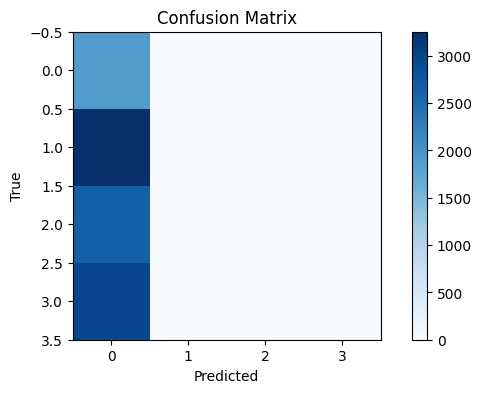

In [ ]:
val_probs = model.predict(val_ds, verbose=0)
y_val_pred = val_probs.argmax(axis=1)

print(classification_report(y_val, y_val_pred, target_names=label_vocab, digits=4))

cm = confusion_matrix(y_val, y_val_pred, labels=list(range(num_classes)))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


## Training history visualization

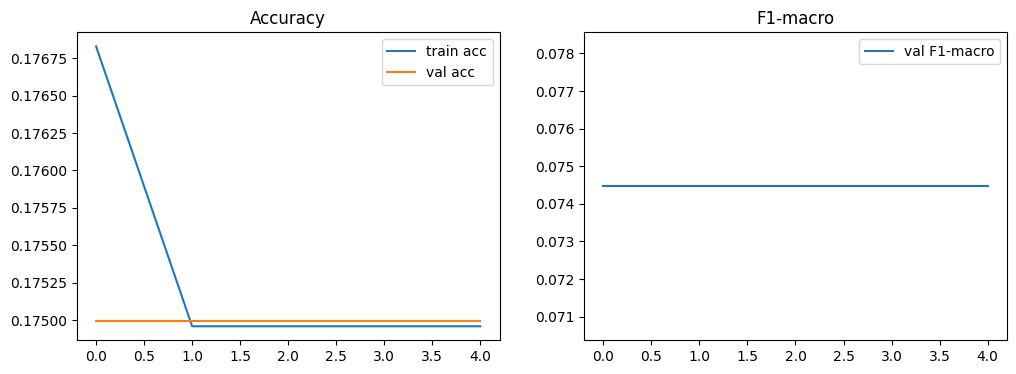

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["val_f1_macro"], label="val F1-macro")
plt.legend()
plt.title("F1-macro")
plt.show()


## Final evaluation on validation/test set

In [ ]:
val_loss, val_acc, val_f1 = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}, F1-macro: {val_f1:.4f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.1755 - f1_macro: 0.0747 - loss: nan
Validation accuracy: 0.1750, F1-macro: 0.0745


### Saveing label mapping (important for inference!)

In [ ]:
import json

label_to_id = {"Irrelevant": 0, "Negative": 1, "Neutral": 2, "Positive": 3}
id_to_label = {v: k for k, v in label_to_id.items()}

with open("./artifacts/label_map.json", "w") as f:
    json.dump(id_to_label, f)


### Model summary logging

 model summary to a text file for documentation:

In [ ]:
with open("./artifacts/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))


## Save artifacts (vectorizer + classifier + label maps)

In [ ]:
import os
import pickle

# Create directory if not exists
os.makedirs("./artifacts", exist_ok=True)

# Save classifier (your trained model)
model.save("./artifacts/transformer_classifier.keras")

# Save vectorizer separately with pickle
with open("./artifacts/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Saved classifier (.keras) and vectorizer (.pkl)")


Approach

We approached this task as a supervised text classification problem. Tweets were first cleaned and explored to understand class distribution and potential noise in the dataset. Since raw text cannot be directly fed to a neural network, we applied a TextVectorization layer to tokenize and convert text into numerical embeddings.

To capture contextual meaning, we designed a Transformer-based classifier rather than relying on simpler models like bag-of-words or RNNs, because transformers are better at handling word dependencies in text. We trained the model with class weights to address imbalance and used callbacks (early stopping, learning rate reduction, checkpoints) to stabilize training.

Evaluation relied not only on accuracy but also macro F1-score, since the dataset was imbalanced and F1 provides a fairer view of performance across all sentiment classes. Finally, we saved the trained classifier and vectorizer as artifacts for deployment and inference on unseen tweets.

👉 In short:
The approach is data cleaning → vectorization → transformer-based classification → balanced training with callbacks → evaluation using accuracy & F1 → saving for inference.